## 1. Import Libraries
Import essential Python libraries for data manipulation, visualization, and modeling.

In [1]:
# SECTION 1: Load Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

sns.set_theme(style="whitegrid")
%matplotlib inline

## 2. Load Dataset
Load the Telco Customer Churn dataset which includes information about customer behavior and churn outcomes.

In [2]:
# SECTION 2: Load Data
df = pd.read_csv("../data/data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Basic Overview

In [3]:
# SECTION 3: Basic Overview
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
df.describe()

Shape: (7043, 21)

Data Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing Values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract          

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## 4. Exploratory Data Analysis (EDA)
Analyze patterns and relationships in the data through visualizations.

### 📊 Exploratory Data Analysis (EDA)
This visualization helps us understand the distribution of churn across different customer segments based on their tenure (New, Intermediate, Loyal).

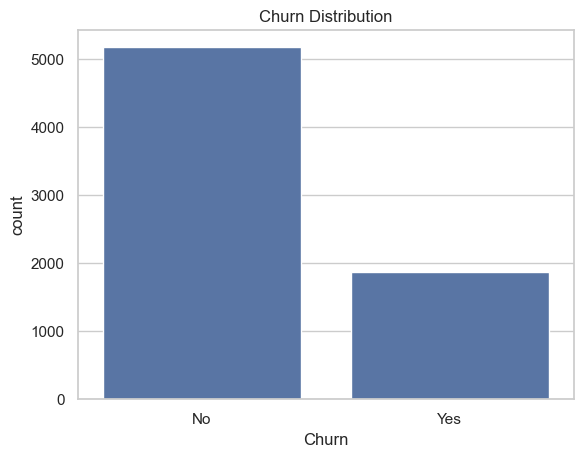

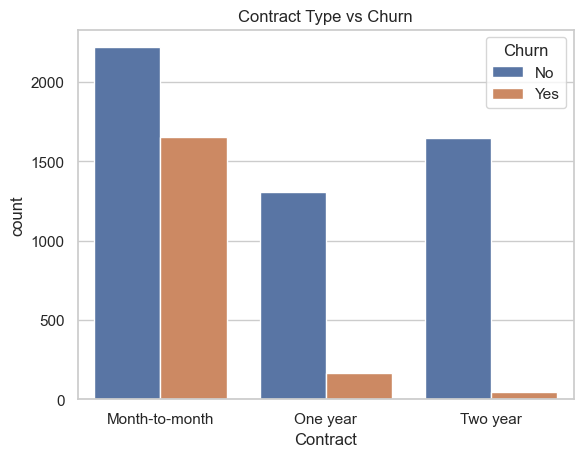

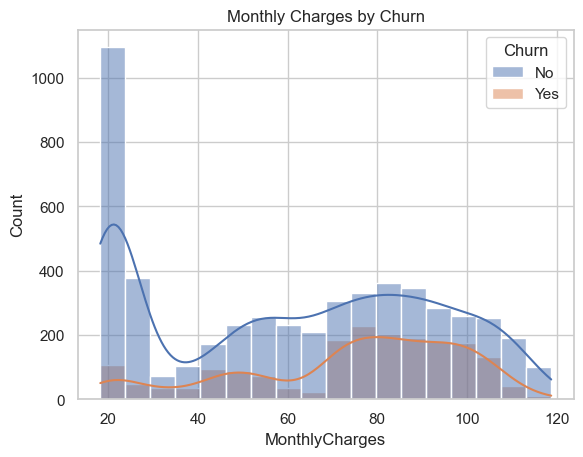

In [4]:
# SECTION 4: Exploratory Data Analysis (EDA)

# Churn distribution
sns.countplot(data=df, x='Churn')
plt.title("Churn Distribution")
plt.show()

# Contract vs Churn
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title("Contract Type vs Churn")
plt.show()

# MonthlyCharges distribution
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True)
plt.title("Monthly Charges by Churn")
plt.show()

### 5.   🔄 Data Preprocessing
- Dropping unnecessary columns (e.g., `customerID`).
- Converting `TotalCharges` to numeric, handling missing values.
- Encoding the target column `Churn` to binary.
- Applying one-hot encoding to all categorical features.
- Splitting data into training and testing sets.

In [5]:
# SECTION 5: Preprocessing

# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# Encode Churn to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Save dropped first categories before encoding
cat_cols = df.select_dtypes(include='object').columns.tolist()
dropped_categories = {col: df[col].sort_values().unique()[0] for col in cat_cols}

os.makedirs("../outputs", exist_ok=True)
with open("../outputs/dropped_categories.json", "w") as f:
    json.dump(dropped_categories, f, indent=4)

# One-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Check post-encoding shape
print("Data shape after encoding:", df.shape)

Data shape after encoding: (7032, 31)


### 6.  📊 Exploratory Data Analysis (EDA)
This visualization helps us understand the distribution of churn across different customer segments based on their tenure (New, Intermediate, Loyal).

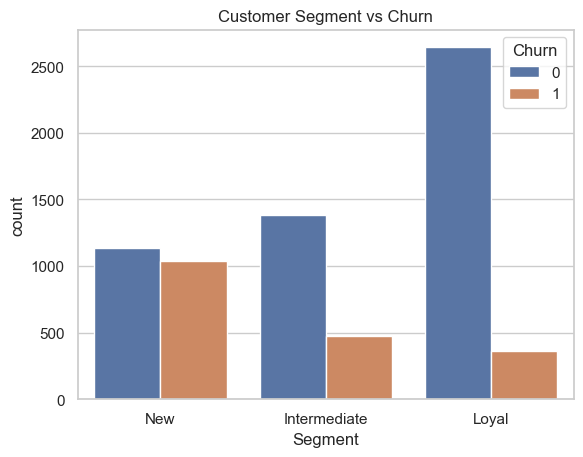

In [6]:
# SECTION 6: Customer Segmentation
# Define segmentation function
def segment_customer(tenure):
    if tenure <= 12:
        return 'New'
    elif tenure <= 36:
        return 'Intermediate'
    else:
        return 'Loyal'

# Apply segmentation
df['Segment'] = df['tenure'].apply(segment_customer)

# Visualize segment vs churn
sns.countplot(data=df, x='Segment', hue='Churn')
plt.title("Customer Segment vs Churn")
plt.show()

# Remove the 'Segment' column (to prevent issues in modeling)
df.drop('Segment', axis=1, inplace=True)

## 7. XGBoost Model

In [7]:
# SECTION 7: Train Default XGBoost Model
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train/test split with stratification to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train XGBoost model
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[890 143]
 [169 205]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      1033
           1       0.59      0.55      0.57       374

    accuracy                           0.78      1407
   macro avg       0.71      0.70      0.71      1407
weighted avg       0.77      0.78      0.78      1407



### 8. 🔧 Hyperparameter Tuning
We use GridSearchCV to find the best combination of parameters for XGBoost. This improves model performance by optimizing `max_depth`, `n_estimators`, and `learning_rate`.

In [8]:
# Section 8: Hyperparameter Tuning (Grid SearchCV)
# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize GridSearchCV with 3-fold cross-validation
grid = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit grid search to training data
grid.fit(X_train, y_train)

# Output best parameters
print("Best Parameters:", grid.best_params_)

# Evaluate tuned model on test data
best_model = grid.best_estimator_
y_pred_tuned = best_model.predict(X_test)

print("\nClassification Report (Tuned Model):\n", classification_report(y_test, y_pred_tuned))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

Classification Report (Tuned Model):
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.62      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



### 9. ⚖️ Class Weighting to Handle Imbalance
To deal with imbalanced churn data, we assign a higher weight to the minority class (churners). `scale_pos_weight` is computed as the ratio of non-churners to churners in the training set.

In [9]:
# SECTION 9: Class Imbalance Handling - Class Weighting
# Calculate class imbalance ratio
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print("Scale Pos Weight:", scale_pos_weight)

# Train XGBoost model with class weighting
model_weighted = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

model_weighted.fit(X_train, y_train)

# Predictions
y_pred_weighted = model_weighted.predict(X_test)

# Evaluation
print("\nClassification Report (Class Weighted Model):\n", classification_report(y_test, y_pred_weighted))

Scale Pos Weight: 2.762541806020067

Classification Report (Class Weighted Model):
               precision    recall  f1-score   support

           0       0.87      0.78      0.82      1033
           1       0.53      0.68      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407



### 10, 🧪 SMOTE: Synthetic Minority Oversampling Technique
SMOTE generates synthetic samples of the minority class (churners) to balance the class distribution. This helps the model learn from an equal representation of both classes.

In [10]:
# SECTION 10: SMOTE for Imbalanced Classes
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Class distribution before and after SMOTE
print("Original y_train class distribution:", np.bincount(y_train))
print("After SMOTE y_train class distribution:", np.bincount(y_train_smote))

# Train XGBoost model on SMOTE-balanced data
model_smote = XGBClassifier(eval_metric='logloss')
model_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_smote = model_smote.predict(X_test)

# Evaluation
print("\nClassification Report (SMOTE Model):\n", classification_report(y_test, y_pred_smote))

Original y_train class distribution: [4130 1495]
After SMOTE y_train class distribution: [4130 4130]

Classification Report (SMOTE Model):
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1033
           1       0.56      0.56      0.56       374

    accuracy                           0.77      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.77      0.77      0.77      1407



## 11. SHAP Model Interpretation
Use SHAP values to interpret feature impact on predictions.

### 🧠 SHAP Interpretation
SHAP (SHapley Additive exPlanations) provides visual interpretation of model predictions. It shows how much each feature contributed to the final decision.

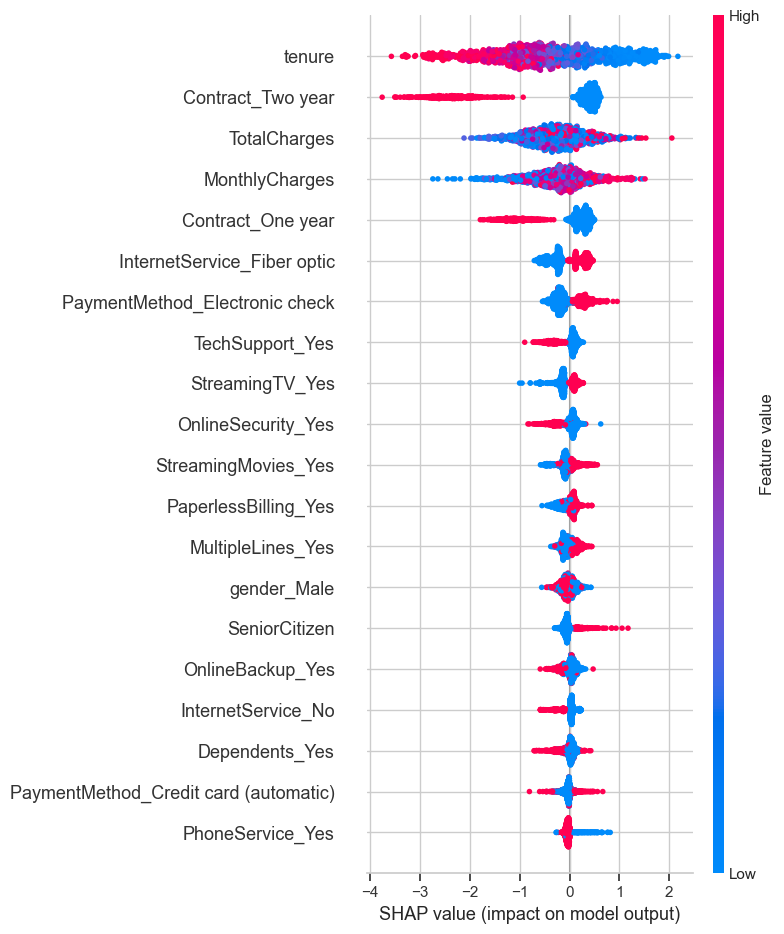

In [11]:
# SECTION 11: Model Interpretation using SHAP (for Class Weighted Model)
# Create SHAP explainer for tree-based model
explainer = shap.Explainer(model_weighted)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Plot summary of feature importance
shap.summary_plot(shap_values, X_test)


### 🧠 Model Training (Default XGBoost Model)

In this step, we train a default XGBoost classifier using the training dataset.
XGBoost is an efficient implementation of gradient boosting which is widely used for structured/tabular data.

**Why XGBoost?**
- Handles missing values internally.
- Regularization to avoid overfitting.
- Built-in support for handling class imbalance (via `scale_pos_weight`).
- Highly scalable and accurate.

We use:
- `eval_metric='logloss'`: for binary classification evaluation
- `train_test_split`: stratified to preserve class balance

Finally, we evaluate using:
- Confusion Matrix
- Precision, Recall, F1-score, and Accuracy



### 🔍 Hyperparameter Tuning with GridSearchCV

We use Grid Search to tune:
- `max_depth`: controls tree depth
- `n_estimators`: number of boosting rounds
- `learning_rate`: step size shrinkage used in updates

**Goal**: Improve model performance by finding optimal hyperparameters.
We use 3-fold cross-validation and optimize for **F1-score** (to balance precision and recall).

After finding the best parameters, we re-train the model and evaluate its performance.



### ⚖️ Handling Imbalance using Class Weights

Customer churn data is imbalanced — more "No Churn" than "Yes Churn".
To handle this, we calculate the ratio of majority to minority class and pass it to `scale_pos_weight` in XGBoost.

**Formula**:
```
scale_pos_weight = count(negative_class) / count(positive_class)
```

This helps the model give more attention to the minority class ("Churn = Yes").



### 🧬 Handling Imbalance using SMOTE (Synthetic Minority Oversampling Technique)

SMOTE oversamples the minority class by synthetically generating new examples.
We apply SMOTE **only on training data** to prevent data leakage.

**Benefits**:
- Avoids overfitting like random oversampling.
- Creates balanced training data.
- Helps model learn patterns for minority class better.

We then train an XGBoost model using the balanced dataset and compare its performance.
